In [84]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [85]:
import numpy as np
import pandas as pd

In [86]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [88]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [89]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [90]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [91]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [92]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [93]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [11]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns("station")
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [172]:
#getting latest and earliest dates.
latest = session.query(func.max(Measurement.date).label("late")).all()
print(latest[0].late)
#The extra day in 2016 is in February so we don't need to worry about it here.
early = dt.datetime.strptime(latest[0].late,"%Y-%m-%d") - dt.timedelta(days=365)
early_date = dt.datetime.strftime(early,"%Y-%m-%d")
print(early_date)

2017-08-23
2016-08-23


In [173]:
sel = [Measurement.date,
      Measurement.prcp.label("rain")]
qry = session.query(*sel).filter(Measurement.date >= early_date).order_by(Measurement.date.asc())
print(qry)

SELECT measurement.date AS measurement_date, measurement.prcp AS rain 
FROM measurement 
WHERE measurement.date >= ? ORDER BY measurement.date ASC


In [174]:
precip = pd.DataFrame(qry.all())
precip = precip.dropna(subset=["rain"])
#precip = precip.sort_values(by = "date")
precip = precip.reset_index(drop = True)
precip = precip.set_index("date",drop=True)
precip.head()

,rain
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


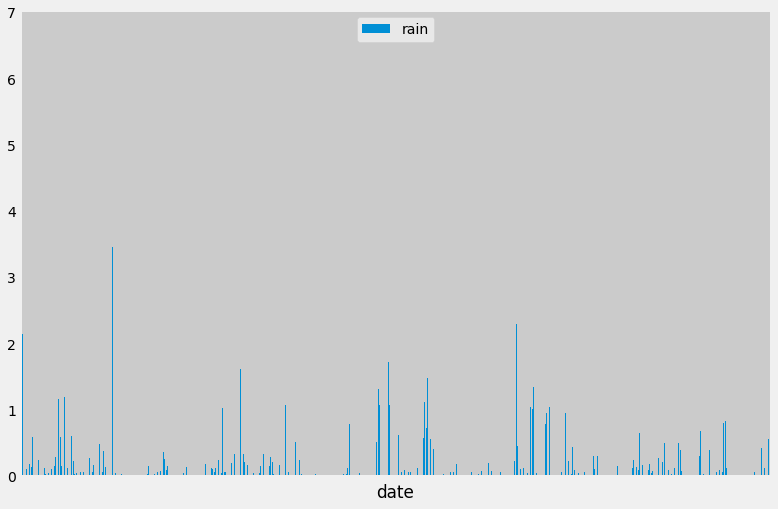

In [184]:
precip.plot(kind="bar",figsize=(12,8))
plt.gca().axes.xaxis.set_ticklabels([])
plt.legend(loc="upper center")
plt.show()
#This graph does not match the provided graph, because the provided graph
#is backwards. Huzzah. We're also not showing peaks here. Don't know why.
#The peaks show up when graphing the same data in other ways.
#They were showing up, and then I ran this and then they weren't

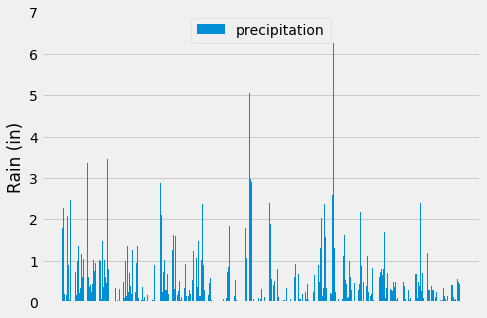

In [183]:
#This plots it using the matplotlib plotting function
fig, ax = plt.subplots(figsize=(7,5))
plt.bar(list(precip.index),list(precip.rain),label="precipitation")
ax.xaxis.grid(which="major",linewidth=0)
plt.ylabel("Rain (in)")
plt.gca().axes.xaxis.set_ticklabels([])
plt.legend(loc="upper center")
plt.show()

![precipitation](Images/precipitation.png)

In [185]:
precip.describe()

,rain
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [145]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [36]:
# Design a query to show how many stations are available in this dataset?
#Station.station works as well
num_stations = session.query(Measurement.station).distinct().count()
print(num_stations)

9


In [95]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(func.count(Measurement.station), \
                Measurement.station).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
print(station_counts)

[(2772, 'USC00519281'), (2724, 'USC00519397'), (2709, 'USC00513117'), (2669, 'USC00519523'), (2612, 'USC00516128'), (2202, 'USC00514830'), (1979, 'USC00511918'), (1372, 'USC00517948'), (511, 'USC00518838')]


In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
ins = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*ins).filter(Measurement.station == station_counts[0][1]).all()

[(54.0, 85.0, 71.66378066378067)]

In [96]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_counts = session.query(func.count(Measurement.tobs), \
                Measurement.station).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
print(station_counts)

[(2772, 'USC00519281'), (2724, 'USC00519397'), (2709, 'USC00513117'), (2669, 'USC00519523'), (2612, 'USC00516128'), (2202, 'USC00514830'), (1979, 'USC00511918'), (1372, 'USC00517948'), (511, 'USC00518838')]


In [72]:
stuffs = session.query(Measurement.tobs).\
    filter(Measurement.station == station_counts[0][1]).\
    filter(Measurement.date >= early_date).\
    order_by(Measurement.date.desc()).all()
stuffs = [tup.tobs for tup in stuffs]

In [73]:
big = max(stuffs)
small = min(stuffs)
bins = list(np.arange(small,big+1,(big-small)/12))
bins

[59.0, 61.0, 63.0, 65.0, 67.0, 69.0, 71.0, 73.0, 75.0, 77.0, 79.0, 81.0, 83.0]

In [76]:
grouper = pd.DataFrame(stuffs, columns = ["Temps"])
grouper = grouper.groupby(pd.cut(grouper.Temps,bins,right=False)).count()
grouper

,Temps
Temps,
"[59.0, 61.0)",5
"[61.0, 63.0)",7
"[63.0, 65.0)",7
"[65.0, 67.0)",12
"[67.0, 69.0)",27
"[69.0, 71.0)",41
"[71.0, 73.0)",40
"[73.0, 75.0)",57
"[75.0, 77.0)",66


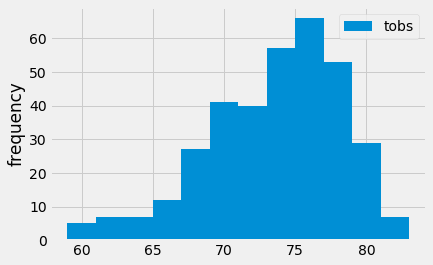

In [80]:
plt.bar(bins[0:(len(bins)-1)],list(grouper.Temps),align="edge",width=(bins[1]-bins[0]),label="tobs")
plt.ylabel("frequency")
plt.legend(loc="upper right")
plt.show()

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [97]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [133]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#Our trip will be using the data from 2016-06-(01-07)
start_date = "2016-06-01"
end_date = "2016-06-07"
groups = calc_temps(start_date,end_date)
groups

[(64.0, 72.37209302325581, 78.0)]

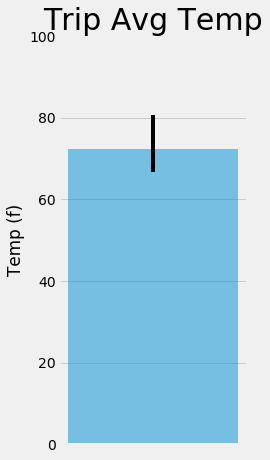

In [135]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = [[groups[0][2]-groups[0][1]],[groups[0][1]-groups[0][0]]]
fig, ax = plt.subplots(figsize=(3,7))
ax.xaxis.grid(which="major",linewidth=0)
plt.bar(0,groups[0][1],yerr=yerr,alpha=.5)
plt.title("Trip Avg Temp",fontsize = 30)
plt.ylabel("Temp (f)")
plt.gca().axes.xaxis.set_ticklabels([])
plt.ylim((0,100))
plt.show()

In [140]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
returnees = [func.sum(Measurement.prcp),Measurement.station,Station.name,\
            Station.latitude,Station.longitude,Station.elevation]

station_counts = session.query(*returnees).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
print(station_counts)

[(1068.0899999999956, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (588.6399999999976, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (382.61999999999847, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (295.67999999999944, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (234.49000000000026, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (131.62000000000063, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (92.68000000000006, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), (70.87000000000005, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), (43.44000000000002, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [141]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [153]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#This will use the start and end date from the previous bonus section,
#They are called start_date and end_date respectively.

# Use the start and end date to create a range of dates
dates = []
date = start_date
while date <= end_date:
    #print(date)
    dates.append(date)
    date = dt.datetime.strptime(date,"%Y-%m-%d") + dt.timedelta(days=1)
    date = dt.datetime.strftime(date,"%Y-%m-%d")

# Stip off the year and save a list of %m-%d strings
naked = [date.split("-",1)[1] for date in dates]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(nak)[0] for nak in naked]
normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0)]

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [160]:
infographic = pd.DataFrame(normals,columns=["tMin","tAvg","tMax"],index = dates)
infographic.index.rename("date",inplace=True)
infographic

,tMin,tAvg,tMax
date,,,
2016-06-01,64.0,74.614035,81.0
2016-06-02,65.0,74.400000,81.0
2016-06-03,65.0,74.034483,80.0
2016-06-04,65.0,73.818182,81.0
2016-06-05,68.0,74.854545,81.0
2016-06-06,70.0,75.175439,80.0
2016-06-07,68.0,75.071429,81.0


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


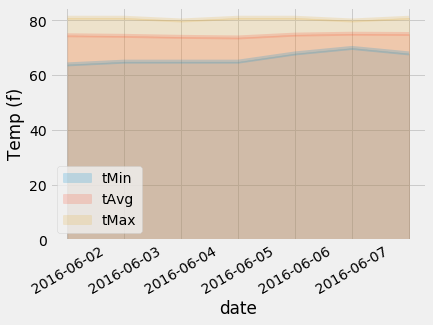

In [171]:
infographic.plot.area(stacked=False,alpha=.2)
plt.gca().axes.xaxis.set_ticklabels(dates)
plt.xticks(rotation=30)
plt.ylabel("Temp (f)")
plt.show()

In [169]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
#Test cell for flask, can be ignored. They don't affect any performance of the code.
#All cells are, in order of appearance, related to the corresponding path in
#order of the paths appearance




In [27]:
#Test cell for flask, can be ignored. They don't affect any performance of the code.
#All cells are, in order of appearance, related to the corresponding path in
#order of the paths appearance
sel = [Measurement.date, func.avg(Measurement.prcp)]
qry = session.query(*sel).filter(Measurement.date >= early_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date.desc()).all()
rain = {pair[0]:pair[1] for pair in qry}
rain

{'2017-08-23': 0.1325,
 '2017-08-22': 0.16666666666666666,
 '2017-08-21': 0.19333333333333336,
 '2017-08-20': 0.005,
 '2017-08-19': 0.03,
 '2017-08-18': 0.02,
 '2017-08-17': 0.0475,
 '2017-08-16': 0.1525,
 '2017-08-15': 0.164,
 '2017-08-14': 0.062,
 '2017-08-13': 0.0,
 '2017-08-12': 0.04666666666666667,
 '2017-08-11': 0.0,
 '2017-08-10': 0.0175,
 '2017-08-09': 0.049999999999999996,
 '2017-08-08': 0.11000000000000001,
 '2017-08-07': 0.0125,
 '2017-08-06': 0.0,
 '2017-08-05': 0.03,
 '2017-08-04': 0.015,
 '2017-08-03': 0.017499999999999998,
 '2017-08-02': 0.075,
 '2017-08-01': 0.04666666666666666,
 '2017-07-31': 0.0,
 '2017-07-30': 0.06,
 '2017-07-29': 0.10166666666666667,
 '2017-07-28': 0.11,
 '2017-07-27': 0.0016666666666666668,
 '2017-07-26': 0.08333333333333333,
 '2017-07-25': 0.08714285714285715,
 '2017-07-24': 0.6539999999999999,
 '2017-07-23': 0.22600000000000003,
 '2017-07-22': 0.7366666666666667,
 '2017-07-21': 0.018571428571428572,
 '2017-07-20': 0.17714285714285713,
 '2017-07-1

In [30]:
a = session.query(Measurement.station).distinct().all()
list(np.ravel(a))

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [33]:
qry3 = session.query(Measurement.date,Measurement.tobs).\
filter(Measurement.date >= early_date).all()
temps = list(np.ravel(qry3))
temps

[('2016-08-23', 81.0),
 ('2016-08-24', 79.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 79.0),
 ('2016-08-27', 77.0),
 ('2016-08-28', 78.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 79.0),
 ('2016-08-31', 80.0),
 ('2016-09-01', 81.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 79.0),
 ('2016-09-04', 75.0),
 ('2016-09-05', 79.0),
 ('2016-09-06', 76.0),
 ('2016-09-07', 76.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 78.0),
 ('2016-09-11', 76.0),
 ('2016-09-12', 78.0),
 ('2016-09-13', 78.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 80.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 81.0),
 ('2016-09-19', 77.0),
 ('2016-09-20', 77.0),
 ('2016-09-21', 78.0),
 ('2016-09-22', 76.0),
 ('2016-09-23', 82.0),
 ('2016-09-24', 81.0),
 ('2016-09-25', 78.0),
 ('2016-09-26', 80.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 79.0),
 ('2016-09-29', 80.0),
 ('2016-09-30', 80.0),
 ('2016-10-01', 80.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

In [ ]:
ins = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
qry4 = session.query(*ins).filter(Measurement.station == station_counts[0][1]).\
    filter(Measurement.date >= ).filter(Measurement.date <= end).all()
qry4

In [14]:
#Seeing if each date is already consolidated for average values. Assumption is it is by station.
tests = session.query(func.count(Measurement.date), Measurement.date).group_by(Measurement.date).limit(15).all()
tests
#Assumption validated. Yaaay.

[(7, '2010-01-01'),
 (7, '2010-01-02'),
 (7, '2010-01-03'),
 (7, '2010-01-04'),
 (6, '2010-01-05'),
 (6, '2010-01-06'),
 (7, '2010-01-07'),
 (7, '2010-01-08'),
 (7, '2010-01-09'),
 (7, '2010-01-10'),
 (7, '2010-01-11'),
 (7, '2010-01-12'),
 (6, '2010-01-13'),
 (7, '2010-01-14'),
 (6, '2010-01-15')]